# Chapter 5: Extra code, drafts, and cut material

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Beta-binomial demos

In [2]:
from scipy.special import binom, betaln

def beta_binom(prior, y):
    """
    Compute the marginal-log-likelihood for a beta-binomial model,
    analytically.

    prior : tuple
        tuple of alpha and beta parameter for the prior (beta distribution)
    y : array
        array with "1" and "0" corresponding to the success and fails respectively
    """
    α, β = prior
    success = np.sum(y)
    trials = len(y)
    return np.log(binom(trials, success)) + betaln(α + success, β+trials-success) - betaln(α, β)

In [3]:
def posterior_grid(ngrid=10, α=1, β=1, heads=6, trials=9):
    grid = np.linspace(0, 1, ngrid)
    prior = stats.beta(α, β).pdf(grid)
    likelihood = stats.binom.pmf(heads, trials, grid)
    posterior = likelihood * prior
    posterior /= posterior.sum()
    return posterior

In [4]:
def normal_harmonic(sd_0, sd_1, y, s=10000):
    post_tau = 1/sd_0**2 + 1/sd_1**2
    posterior_samples = stats.norm(loc=(y/sd_1**2)/post_tau, scale=(1/post_tau)**0.5).rvs((s, len(x)))
    log_likelihood = stats.norm.logpdf(loc=x, scale=sd_1, x=posterior_samples).sum(1)
    return 1/np.mean(1/log_likelihood)

In [5]:
from scipy import stats
σ_0 = 1
σ_1 = 1
y = np.array([0])
stats.norm.logpdf(loc=0, scale=(σ_0**2+σ_1**2)**0.5, x=y).sum()

-1.2655121234846454

In [6]:
def posterior_ml_ic_normal(σ_0=1, σ_1=1, y=[1]):
    n = len(y)
    var_μ = 1/((1/σ_0**2) + (n/σ_1**2))
    μ = var_μ * np.sum(y)/σ_1**2
    σ_μ = var_μ**0.5

    posterior = stats.norm(loc=μ, scale=σ_μ)
    samples = posterior.rvs(size=(2, 1000))
    log_likelihood = stats.norm(loc=samples[:, :, None], scale=σ_1).logpdf(y)
    idata = az.from_dict(log_likelihood={'o': log_likelihood})

    log_ml = stats.norm.logpdf(loc=0, scale=(σ_0**2+σ_1**2)**0.5, x=y).sum()
    
    x = np.linspace(-5, 6, 300)
    density = posterior.pdf(x)
    
    return μ, σ_μ, x, density, log_ml, az.waic(idata).elpd_waic, az.loo(idata, reff=1).elpd_loo

Text(0.5, 0, 'μ')

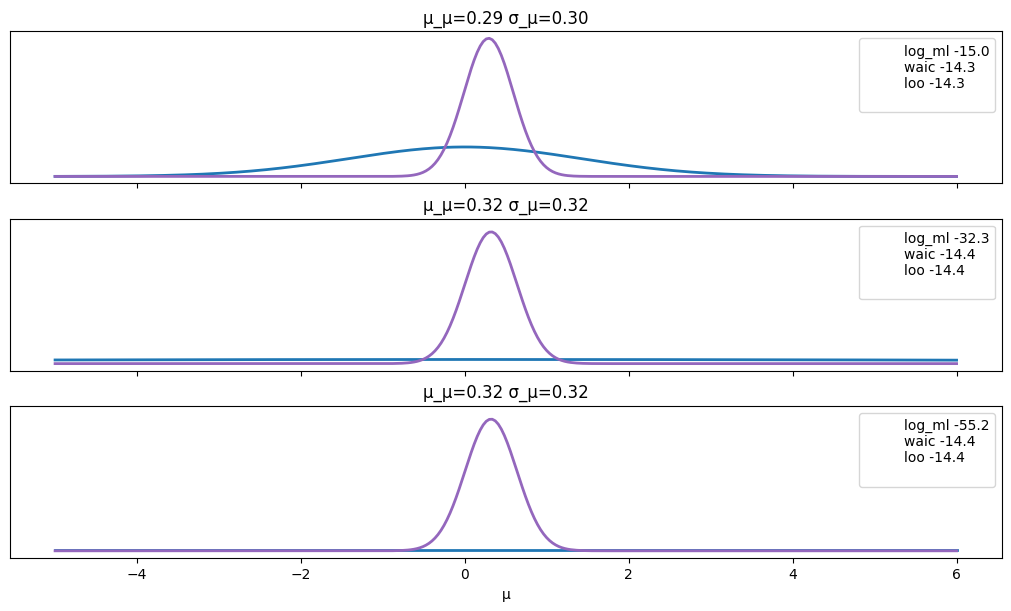

In [7]:
import arviz as az

y = np.array([ 0.65225338, -0.06122589,  0.27745188,  1.38026371, -0.72751008,
              -1.10323829,  2.07122286, -0.52652711,  0.51528113,  0.71297661])

_, ax = plt.subplots(3, figsize=(10, 6), sharex=True, sharey=True,
                     constrained_layout=True)

for i, σ_0 in enumerate((1, 10, 100)):
    μ_μ, σ_μ, x, density, log_ml, waic, loo = posterior_ml_ic_normal(σ_0, σ_1, y)
    ax[i].plot(x, stats.norm(loc=0, scale=(σ_0**2+σ_1**2)**0.5).pdf(x), lw=2)
    ax[i].plot(x, density, lw=2, color='C4')
    ax[i].plot(0, label=f'log_ml {log_ml:.1f}\nwaic {waic:.1f}\nloo {loo:.1f}\n', alpha=0)
    ax[i].set_title(f'μ_μ={μ_μ:.2f} σ_μ={σ_μ:.2f}')
    ax[i].legend()
ax[2].set_yticks([])

ax[2].set_xlabel("μ")

#plt.savefig("img/chp11/ml_waic_loo.png")

In [8]:
σ_0 = 1
σ_1 = 1
y = np.array([0])
stats.norm.logpdf(loc=0, scale=(σ_0**2 + σ_1**2)**0.5, x=y).sum()

-1.2655121234846454

In [9]:
def posterior_grid(ngrid=10, α=1, β=1, heads=6, trials=9):
    grid = np.linspace(0, 1, ngrid)
    prior = stats.beta(α, β).pdf(grid)
    likelihood = stats.binom.pmf(heads, trials, grid)
    posterior = likelihood * prior
    posterior /= posterior.sum()
    return posterior

## Bayesian p-value

In [10]:
import pymc as pm
import numpy as np
import arviz as az

# Simulated data
np.random.seed(42)
x = np.random.normal(0, 1, 100)
y = 3 + 2 * x + np.random.normal(0, 1, 100)

# Bayesian Linear Regression Model
with pm.Model() as model:
    # Priors
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    # Likelihood
    mu = beta0 + beta1 * x
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
    
    # Sampling
    trace = pm.sample(2000, return_inferencedata=True)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


In [11]:
# Posterior Predictive Check
# with model:
#     ppc = pm.sample_posterior_predictive(trace)    
# Posterior Predictive Check
ppc = pm.sample_posterior_predictive(trace, model=model)
    


Sampling: [y_obs]


Output()

In [12]:
# Extract the posterior predictive samples for 'y_obs'
y_rep = ppc.posterior_predictive["y_obs"].values

# Calculate Bayesian p-value for the slope
test_stat_observed = np.mean(y)  # Example test statistic
test_stat_rep = np.mean(y_rep, axis=1)
bayesian_p_value = np.mean(test_stat_rep >= test_stat_observed)
print("Bayesian p-value:", bayesian_p_value)

Bayesian p-value: 0.49


In [13]:
# manual numerical integral function to check posterior is well normalized
def myint(xs, ys):
    delta = xs[1] - xs[0]
    return np.sum(ys) * delta

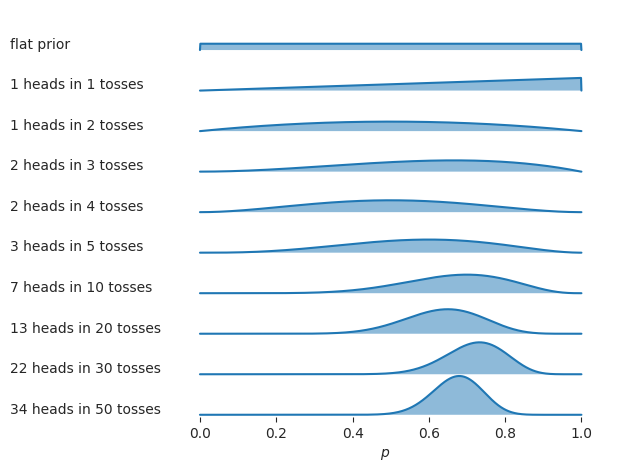

In [14]:
# FIGURES ONLY
# Inspired by  https://python-graph-gallery.com/ridgeline-graph-seaborn/
from scipy.stats import beta



n_rows = 10
ns =       [0, 1, 2, 3, 4, 5, 10, 20, 30,  50]
outcomes = [0, 1, 1, 2, 2, 3,  7, 13, 22,  34]
# outcomes were generated from coin with true p = 0.7
assert len(outcomes) == n_rows
assert len(ns) == n_rows
n_rows = int(len(outcomes))

dists = pd.DataFrame({
    "case": range(n_rows),
    "n": ns,
    "outcome": outcomes,
})

labels = []
for i in range(n_rows):
    heads, n = outcomes[i], ns[i]
    if i==0:
        label = "flat prior"
    else:
        label = f"{heads} heads in {n} tosses"
    labels.append(label)


def plot_case(heads, n, *args, **kwargs):
    rvPpost = beta(a=1+heads, b=1+n-heads)
    eps = 0.001
    ps = np.linspace(0-eps, 1.0+eps, 1000)
    rvPpdf = rvPpost.pdf(ps)
    ax = sns.lineplot(x=ps, y=rvPpdf, alpha=1)
    ax.fill_between(ps, 0, rvPpdf, alpha=0.5)

with sns.axes_style("white"), plt.rc_context({"axes.facecolor": (0, 0, 0, 0), "xtick.bottom":True}):
    g = sns.FacetGrid(dists, row='case', aspect=12, height=0.5)
    g.map(plot_case, "outcome", "n")
    
    # add labels on the left
    for i, ax in enumerate(g.axes.flat):
        ax.text(-0.5, 0.3, labels[i], fontsize=10, ha="left", multialignment="right")

    # adjust spacing to get the axes to overlap
    g.fig.subplots_adjust(hspace=-0.05)

    # other figure cleanup
    g.set(xlim=[-0.3,1.1])
    g.set(xticks=np.linspace(0,1,6))
    for i, ax in enumerate(g.axes.flat):
        if i != n_rows-1:
            # remove x-ticks (except for last)
            ax.tick_params(bottom=False)
    g.set(xlabel="               $p$")
    g.set_titles(template="")
    g.set(yticks=[])
    g.set(ylabel=None)
    g.despine(bottom=True, left=True)

    # save as PDF and PNG
    # filename = os.path.join(DESTDIR, "ridgeplot_coin_posteriors.pdf")
    # fig = plt.gcf()
    # fig.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0)
    # filename2 = filename.replace(".pdf", ".png")
    # fig.savefig(filename2, dpi=300, bbox_inches="tight", pad_inches=0)
    # print("Saved figure to", filename)    
    # print("Saved figure to", filename2)

### Maximum a posteriori estimates

In [15]:
iqs = [ 82.6, 105.5,  96.7,  84.0, 127.2,  98.8,  94.3,
       122.1,  86.8,  86.1, 107.9, 118.9, 116.5, 101.0,
        91.0, 130.0, 155.7, 120.8, 107.9, 117.1, 100.1,
       108.2,  99.8, 103.6, 108.1, 110.3, 101.8, 131.7,
       103.8, 116.4]

iqs_out = iqs.copy()
iqs_out[0] = 300
iqs_out[1] = 300
np.mean(iqs_out)

121.55333333333334

In [16]:
# ML
from scipy.stats import norm

muso = np.linspace(-100, 300, 100001)
sigma = 15
likelihood2o = np.ones(100001)
for iq_out in iqs_out:
    likelihood_iq_out = norm(loc=muso, scale=sigma).pdf(iq_out)
    likelihood2o = likelihood2o * likelihood_iq_out

mu_ML = muso[np.argmax(likelihood2o)]
print(mu_ML)

121.55199999999999


In [17]:
# MAP
prior2o = norm(loc=100, scale=10).pdf(muso)
numerator2o = likelihood2o * prior2o
posterior2o = numerator2o / np.sum(numerator2o)

# posterior mode 
muso[np.argmax(posterior2o)]

120.048

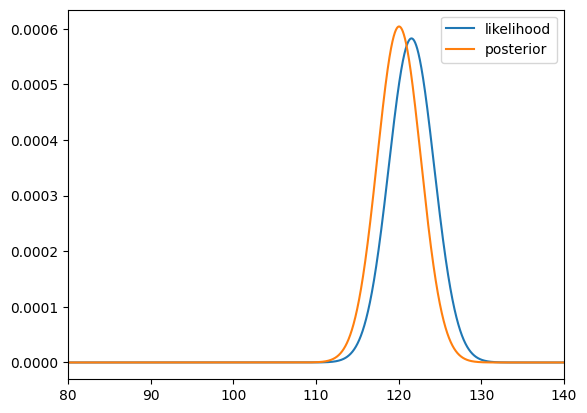

In [18]:
ax = sns.lineplot(x=muso, y=likelihood2o/np.sum(likelihood2o), label="likelihood")
sns.lineplot(x=muso, y=posterior2o/np.sum(posterior2o), ax=ax, label="posterior")
ax.set_xlim([80,140]);

### Example 1 using PyMC

In [19]:
import pandas as pd
import pymc as pm


ctosses = pd.read_csv("../datasets/exercises/ctosses.csv")

with pm.Model() as model:
    # Specify the prior distribution of unknown parameter
    P = pm.Beta("P", alpha=1, beta=1)
    # Specify the likelihood distribution and condition on the observed data
    y_obs = pm.Binomial("y_obs", n=1, p=P, observed=ctosses)
    # Sample from the posterior distribution
    idata1_alt = pm.sample(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [P]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


In [20]:
pred_dists1 = (pm.sample_prior_predictive(1000, model).prior_predictive["y_obs"].values,
              pm.sample_posterior_predictive(idata1_alt, model).posterior_predictive["y_obs"].values)

Sampling: [P, y_obs]
Sampling: [y_obs]


Output()

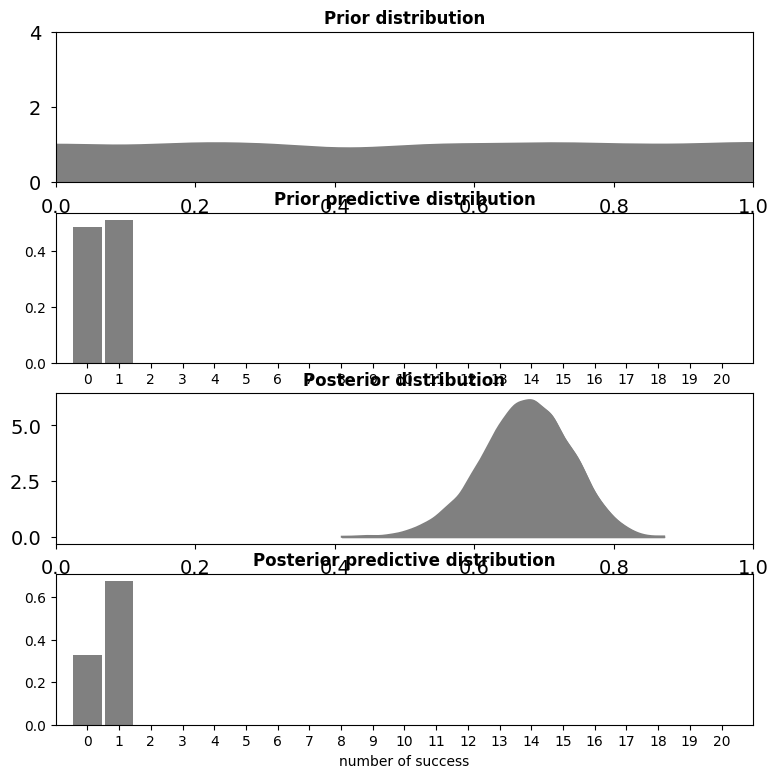

In [21]:
fig, axes = plt.subplots(4, 1, figsize=(9, 9))

for idx, n_d, dist in zip((1, 3), ("Prior", "Posterior"), pred_dists1):
    az.plot_dist(dist.sum(-1), 
                 hist_kwargs={"color":"0.5", "bins":range(0, 22)},
                 ax=axes[idx])
    axes[idx].set_title(f"{n_d} predictive distribution", fontweight='bold')
    axes[idx].set_xlim(-1, 21)
    axes[idx].set_xlabel("number of success")

az.plot_dist(pm.draw(P, 1000),
             plot_kwargs={"color":"0.5"},
             fill_kwargs={'alpha':1}, ax=axes[0])
axes[0].set_title("Prior distribution", fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 4)
axes[0].tick_params(axis='both', pad=7)
axes[0].set_xlabel("p")

az.plot_dist(idata1_alt.posterior["P"],
             plot_kwargs={"color":"0.5"},
             fill_kwargs={'alpha':1},
             ax=axes[2])
axes[2].set_title("Posterior distribution", fontweight='bold')
axes[2].set_xlim(0, 1)
axes[2].tick_params(axis='both', pad=7)
axes[2].set_xlabel("p");

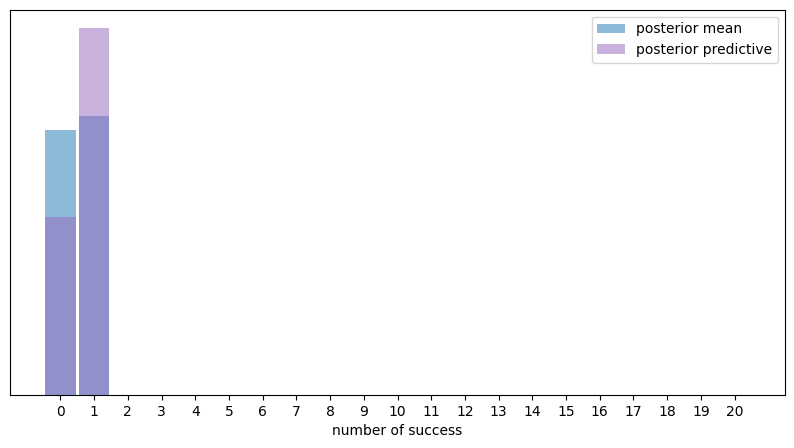

In [22]:
# ???
from scipy.stats import binom
predictions1 = (binom(n=1, p=idata1_alt.posterior["P"].mean()).rvs((4000, len(ctosses))),
               pred_dists1[1])
for d, c, l in zip(pred_dists1, ("C0", "C4"), ("posterior mean", "posterior predictive")):
    ax = az.plot_dist(d.sum(-1),
                      label=l,
                      figsize=(10, 5),
                      hist_kwargs={"alpha": 0.5, "color":c, "bins":range(0, 22)})
    ax.set_yticks([])
    ax.set_xlabel("number of success")

### Verify IQ computation against the R package `BayesFactor`

In [23]:
iqs = [ 82.6, 105.5,  96.7,  84.0, 127.2,  98.8,  94.3,
       122.1,  86.8,  86.1, 107.9, 118.9, 116.5, 101.0,
        91.0, 130.0, 155.7, 120.8, 107.9, 117.1, 100.1,
       108.2,  99.8, 103.6, 108.1, 110.3, 101.8, 131.7,
       103.8, 116.4]

import rpy2.robjects as robjects
from rpy2.robjects import r as runr, pandas2ri
from rpy2.robjects.packages import importr
pandas2ri.activate()

# import the BayesFactor package
BayesFactor = importr('BayesFactor')

# copy the data sample into the R workspace
robjects.globalenv["iqs"] = np.array(iqs)

# compute the Bayes factor
runr('bf = ttestBF(iqs, mu=100)')
runr('print(bf)')

Bayes factor analysis
--------------
[1] Alt., r=0.707 : 3.739463 ±0%

Against denominator:
  Null, mu = 100 
---
Bayes factor type: BFoneSample, JZS



In [24]:
# ALT. likelihood calculations for Example 1 in Sec 5.1
ngrid1 = 101             # number of points in the grid
ps = np.linspace(0, 1, ngrid1) # [0, 0.01, ..., 1.0]

ctosses = [1,1,0,0,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,1,
           1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,0,1,0,
           0,1,0,1,0,1,0,1,1,0]

from scipy.stats import bernoulli
likelihood1 = np.ones(ngrid1)
for ctoss in ctosses:
    likelihood_ctoss = bernoulli(p=ps).pmf(ctoss)
    likelihood1 = likelihood1 * likelihood_ctoss


# ALT2:
# np.prod(bernoulli(p=ps[:,np.newaxis]).pmf(ctosses), axis=1)

# likelihood1[0:101:25]
list(map(lambda x: float("{:1.3g}".format(x)), likelihood1[0:101:25]))

[0.0, 3.4e-23, 8.88e-16, 1.32e-14, 0.0]

In [25]:
iqs = [ 82.6, 105.5,  96.7,  84.0, 127.2,  98.8,  94.3,
       122.1,  86.8,  86.1, 107.9, 118.9, 116.5, 101.0,
        91.0, 130.0, 155.7, 120.8, 107.9, 117.1, 100.1,
       108.2,  99.8, 103.6, 108.1, 110.3, 101.8, 131.7,
       103.8, 116.4]

ngrid2 = 1001  # number of points in the grid
mus = np.linspace(80, 120, ngrid2)

# ALT. one-line computation using NumPy broadcasting rules
likelihood2 = np.prod(norm(loc=mus[:,np.newaxis], scale=15).pdf(iqs), axis=1)
likelihood2[0:1001:300]

array([1.23613569e-77, 1.80497559e-62, 1.20898934e-55, 3.71466415e-57])

### ALT stuff form Sec 5.2

In [26]:
# ALT. load the `ctosses` data frame from the exercises/ folder
df1 = pd.read_csv("../datasets/exercises/ctosses.csv")
# df1.head()

In [27]:
# BONUS DEMO: simulate a random sample from the model

# params
n = len(df1)
true_p = 0.7

# gen a random data frame DF1 like df1
from scipy.stats import bernoulli
ctosses = bernoulli(p=true_p).rvs(n)
DF1 = pd.DataFrame({"heads": ctosses})
DF1["heads"].values, DF1["heads"].mean()

(array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1]),
 0.8)

In [28]:
# BONUS DEMO 2: simulate a random sample from the prior predictive distribution
# np.random.seed(47)
n = len(df1)

# gen parameters p independently for each observation
from scipy.stats import uniform
true_ps = uniform(0,1).rvs(n)

# gen a random data sample of size n
from scipy.stats import bernoulli
ctosses = bernoulli(p=true_ps).rvs(n)
DF1 = pd.DataFrame({"ctoss": ctosses})
DF1["ctoss"].values, DF1["ctoss"].mean()

(array([0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 1]),
 0.48)

In [29]:
# ALT. load the `iqs.csv` data file from the exercises/ folder
iqs = pd.read_csv("../datasets/exercises/iqs.csv")
iqs["iq"].mean()

107.82333333333334

In [30]:
import bambi as bmb

priors2 = {
    "Intercept": bmb.Prior("Normal", mu=100, sigma=40),
    "sigma": bmb.Prior("Data", value=15),
    # "sigma": 15,  # CHANGE WHEN https://github.com/bambinos/bambi/pull/851/files LANDS
}

mod2 = bmb.Model(formula="iq ~ 1",
                 family="gaussian",
                 link="identity",
                 priors=priors2,
                 data=iqs)

mod2.set_alias({"Intercept":"M"})
mod2.build()
mod2

       Formula: iq ~ 1
        Family: gaussian
          Link: mu = identity
  Observations: 30
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 100.0, sigma: 40.0)
        
        Auxiliary parameters
            sigma ~ Data(value: 15.0)

In [31]:
# Inspect different types of variables in the model
mod2.backend.model.data_vars, \
mod2.backend.model.observed_RVs, \
mod2.backend.model.unobserved_RVs

([sigma], [iq], [M, mu])

### Choice of priors

Different priors lead to different posteriors.

See `Code 1.8 and Figure 1.7` in
[chp_01.ipynb](./explorations/PyBayesianBookCode/notebooks_updated/chp_01.ipynb)

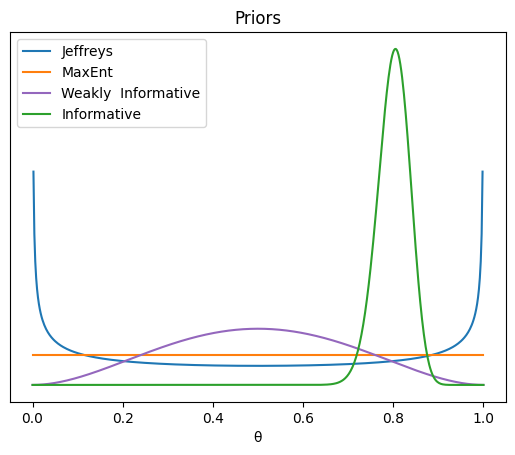

In [32]:
from scipy.stats import beta

x = np.linspace(0, 1, 500)
params = [(0.5, 0.5), (1, 1), (3,3), (100, 25)]

labels = ["Jeffreys",
          "MaxEnt",
          "Weakly  Informative",
          "Informative"]

_, ax = plt.subplots()
for (α, β), label, c in zip(params, labels, (0, 1, 4, 2)):
    pdf = beta.pdf(x, α, β)
    ax.plot(x, pdf, label=f"{label}", c=f"C{c}")
    ax.set(yticks=[], xlabel="θ", title="Priors")
    ax.legend()
# plt.savefig("img/chp01/prior_informativeness_spectrum.png")

In [33]:
# Bayes factors: plot of Savage-Dickey density ratio
# idata_prior = mod2.prior_predictive()
# idata2.add_groups({"prior":idata_prior["prior"]})
# az.plot_bf(idata2, var_name="M", ref_val=100)

### Alternative for extracting the samples from the posterior

Another option is to use the method `.stack` on the `DataArray`
to combine the `chain` and `draw` indices.
The overall procedure has four steps:

1. select the group `"posterior"`
2. select the variable `P`
3. combine the `chain` (0...3) and `draw` (0...999) indices into a single index `sample` (0...3999)
4. extract the actual values

In [34]:
# ALT. manually extract the samples from the posterior
idata1 = idata1_alt
postP = (idata1["posterior"]                     # (1) 
               ["P"]                             # (2)
               .stack(sample=("chain", "draw"))  # (3)
               .values)                          # (4)
postP

array([0.64421595, 0.52880355, 0.52880355, ..., 0.6782993 , 0.73897952,
       0.81471326])

### Debugging and detailed printing

In [35]:
mod2.backend.model

In [36]:
from pymc.printing import str_for_dist, str_for_model, str_for_potential_or_deterministic
print(str_for_model(mod2.backend.model))

 M ~ Normal(100, 40)
mu ~ Deterministic(f(M))
iq ~ Normal(mu, 15)


In [37]:
# DEBUG INFO
import pytensor

with mod2.backend.model:
    # Retrieve the deterministic variable
    deterministic_var = mod2.backend.model['mu']  # Replace 'p' with the actual name of your deterministic variable

    # Print the details of the deterministic variable
    print(deterministic_var)
    print(deterministic_var.type)
    pytensor.printing.debugprint(deterministic_var)
    print(str_for_potential_or_deterministic(deterministic_var))

mu
Vector(float64, shape=(30,))
Identity [id A] 'mu'
 └─ Add [id B]
    ├─ ExpandDims{axis=0} [id C]
    │  └─ 0 [id D]
    └─ Mul [id E]
       ├─ ExpandDims{axis=0} [id F]
       │  └─ normal_rv{"(),()->()"}.1 [id G] 'M'
       │     ├─ RNG(<Generator(PCG64) at 0x30888A420>) [id H]
       │     ├─ NoneConst{None} [id I]
       │     ├─ 100.0 [id J]
       │     └─ 40.0 [id K]
       └─ [1. 1. 1. ... 1. 1. 1.] [id L]
mu ~ Deterministic(f(M))


## Example 1: eight schools

cf. centered non-centered example in NumPyro
https://github.com/pyro-ppl/numpyro?tab=readme-ov-file#a-simple-example---8-schools


In [38]:
J = 8
ys = [28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]
sigmas = [15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]

schools = pd.DataFrame({"school":range(1,J+1),
                        "y":ys,
                        "sigma":sigmas})

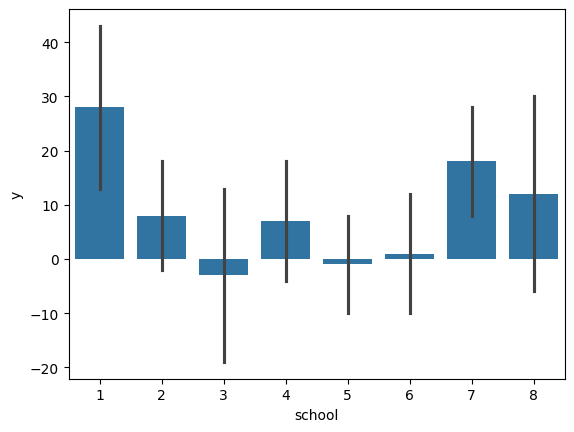

In [39]:
# ALT. bar-plot using plt
# plt.bar(range(J), ys, yerr=sigmas);

# duplicate schools to trigger the errorbar logic in `sns.barplot`
dblschools = pd.concat([schools,schools])

def errorbar4y(y):
    """
    Custom function to draw error bar taken from the `sigma` column.
    """
    yval = y.values[0]
    sigma = schools[schools["y"]==yval]["sigma"]
    return (yval-sigma, yval+sigma)

sns.barplot(x="school", y="y", errorbar=errorbar4y, data=dblschools);

### Logistic regression analyzing results

In [40]:
# # ALT. manually extract
# ps42 = preds42["posterior"]["p"].values.flatten()
# ps42.mean(), az.hdi(ps42, hdi_prob=0.94)
# and plot...
# sns.histplot(x=ps42);

In [41]:
# # MANUAL compute of mu_score
# idata1_rep = mod1.predict(idata1, inplace=False, kind="response")

# # Calculate the model mean
# post1 = idata1_rep["posterior"]
# efforts = students["effort"]
# post1["score_model"] = post1["Intercept"] + post1["effort"] * xr.DataArray(efforts)

## Bayesian Linear Regression (BONUS)

from [cs109b_lect13_bayes_2_2021.ipynb](./explorations/cs109b_lect13_bayes_2_2021.ipynb)


We will artificially create the data to predict on. We will then see if our model predicts them correctly.

In [42]:
np.random.seed(123)

######## True parameter values 
##### our model does not see these
sigma = 1
beta0 = 1
beta = [1, 2.5]   
###############################
# Size of dataset
size = 100

# Feature variables
x1 = np.linspace(0, 1., size)
x2 = np.linspace(0,2., size)

# Create outcome variable with random noise
Y = beta0 + beta[0]*x1 + beta[1]*x2 + np.random.randn(size)*sigma

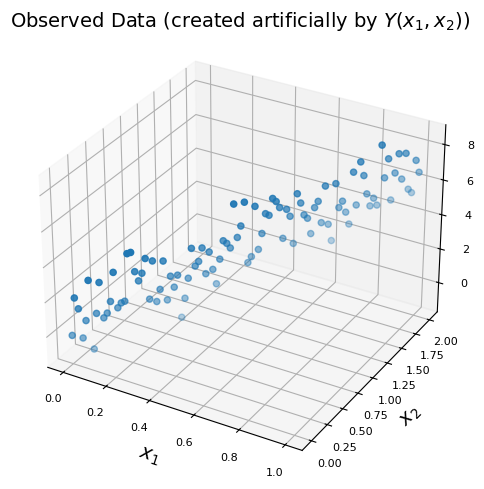

In [43]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
fontsize=14
labelsize=8
title='Observed Data (created artificially by ' + r'$Y(x_1,x_2)$)'
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x1, x2, Y)
ax.set_xlabel(r'$x_1$', fontsize=fontsize)
ax.set_ylabel(r'$x_2$', fontsize=fontsize)
ax.set_zlabel(r'$Y$', fontsize=fontsize)

ax.tick_params(labelsize=labelsize)

fig.suptitle(title, fontsize=fontsize)        
fig.tight_layout(pad=.1, w_pad=10.1, h_pad=2.)
#fig.subplots_adjust(); #top=0.5
plt.tight_layout
plt.show()

Now let's see if our model will correctly predict the values for our unknown parameters, namely $b_0$, $b_1$, $b_2$ and $\sigma$.

#### Defining the Problem

Our problem is the following: we want to perform multiple linear regression to predict an outcome variable $Y$ which depends on variables $\bf{x}_1$ and $\bf{x}_2$.

We will model $Y$ as normally distributed observations with an expected value $mu$ that is a linear function of the two predictor variables, $\bf{x}_1$ and $\bf{x}_2$.

\begin{equation}
Y \sim  \mathcal{N}(\mu,\,\sigma^{2})
\end{equation} 

\begin{equation}
\mu = \beta_0 + \beta_1 \bf{x}_1 + \beta_2 x_2 
\end{equation}

where $\sigma^2$ represents the measurement error (in this example, we will use $\sigma^2 = 10$)

We also choose the parameters to have normal distributions with those parameters set by us.

\begin{eqnarray}
\beta_i \sim  \mathcal{N}(0,\,10) \\
\sigma^2 \sim  |\mathcal{N}(0,\,10)|
\end{eqnarray}   

#### Defining a Model in PyMC

In [44]:
with pm.Model() as my_linear_model:

    # Priors for unknown model parameters, specifically created stochastic random variables 
    # with Normal prior distributions for the regression coefficients,
    # and a half-normal distribution for the standard deviation of the observations.
    # These are our parameters. P(theta)

    beta0 = pm.Normal('beta0', mu=0, sigma=10)
    # Note: betas is a vector of two variables, b1 and b2, (denoted by shape=2)
    # so, in array notation, our beta1 = betas[0], and beta2=betas[1]
    betas = pm.Normal('betas', mu=0, sigma=10, shape=2) 
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # mu is what is called a deterministic random variable, which implies that its value is completely
    # determined by its parents’ values (betas and sigma in our case). 
    # There is no uncertainty in the variable beyond that which is inherent in the parents’ values
    
    mu = beta0 + betas[0]*x1 + betas[1]*x2
    
    # Likelihood function = how probable is my observed data?
    # This is a special case of a stochastic variable that we call an observed stochastic.
    # It is identical to a standard stochastic, except that its observed argument, 
    # which passes the data to the variable, indicates that the values for this variable were observed, 
    # and should not be changed by any fitting algorithm applied to the model. 
    # The data can be passed in the form of either a numpy.ndarray or pandas.DataFrame object.
    
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

**Note**: If our problem was a classification for which we would use Logistic regression see [below](#LR) <BR>
    
**Python Note**: `pm.Model` is designed as a simple API that abstracts away the details of the inference. For the use of `with` see [Compounds statements in Python.](https://docs.python.org/3/reference/compound_stmts.html).

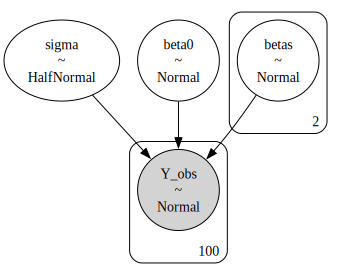

In [45]:
## do not worry about this, it's just a nice graph to have
## you need to install python-graphviz first
# conda install -c conda-forge python-graphviz
pm.model_to_graphviz(my_linear_model)

#### Fitting the Model with Sampling - Doing Inference

See below for PyMC3's sampling method. As you can see it has quite a few parameters. Most of them are set to default values by the package. For some, it's useful to set your own values.
```
pymc3.sampling.sample(draws=500, step=None, n_init=200000, chains=None, 
                      cores=None, tune=500, random_seed=None)
```

Parameters to set:

- **draws**: (int): Number of samples to keep when drawing, defaults to 500. Number starts after the tuning has ended. 
- **tune**: (int): Number of iterations to use for tuning the model, also called the burn-in period, defaults to 500. Samples from the tuning period will be discarded.
- **target_accept** (float in $[0, 1]$). The step size is tuned such that we approximate this acceptance rate. Higher values like 0.9 or 0.95 often work better for problematic posteriors.
- (optional) **chains** (int) number of chains to run in parallel, defaults to the number of CPUs in the system, but at most 4.

`pm.sample` returns a `pymc3.backends.base.MultiTrace` object that contains the samples. We usually name it a variation of the word `trace`. All the information about the posterior is in `trace`, which also provides statistics about the sampler.

In [46]:
## uncomment this to see more about pm.sample
#help(pm.sample)

In [47]:
with my_linear_model:
    print(f'Starting MCMC process')
    # draw nsamples posterior samples and run the default number of chains = 4 
    nsamples = 1000 # number of samples to keep
    burnin = 1000 # burnin period
    trace = pm.sample(nsamples, tune=burnin, target_accept=0.8) 
    print(f'DONE')

Starting MCMC process


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, betas, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


DONE


In [48]:
var_names = trace["posterior"].data_vars
# # var_names = var_names.remove('sigma_log__')
var_names = ["beta0", "sigma"]

#### Model Plotting

PyMC3 provides a variety of visualizations via plots: [https://docs.pymc.io/api/plots.html](https://docs.pymc.io/api/plots.html). `arviz` is another library that you can use.

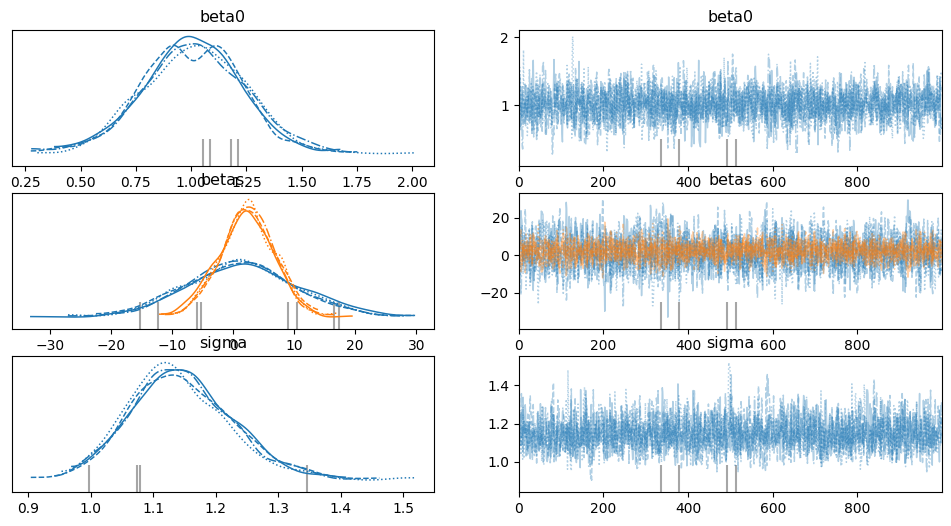

In [49]:
az.plot_trace(trace);

In [50]:
# generate results table from trace samples
# remember our true hidden values sigma = 1, beta0 = 1, beta = [1, 2.5] 
# We want R_hat < 1.1
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,1.008,0.229,0.558,1.420,0.005,0.004,2119.0,1847.0,1.0
betas[0],1.409,8.968,-14.181,19.414,0.239,0.169,1410.0,1491.0,1.0
betas[1],2.316,4.487,-6.720,10.103,0.119,0.084,1417.0,1505.0,1.0
sigma,1.145,0.082,0.995,1.301,0.002,0.001,2262.0,2188.0,1.0


In [51]:
#help(pm.Normal)

$\hat{R}$ is a metric for comparing how well a chain has converged to the equilibrium distribution by comparing its behavior to other randomly initialized Markov chains. Multiple chains initialized from different initial conditions should give similar results.
If all chains converge to the same equilibrium, $\hat{R}$ will be 1. If the chains have not converged to a common distribution, $\hat{R}$ will be > 1.01. $\hat{R}$ is a necessary but not sufficient condition.

For details on the $\hat{R}$ see *Gelman and Rubin (1992)*. 

This linear regression example is from the original paper on PyMC3: *Salvatier J, Wiecki TV, Fonnesbeck C. 2016. Probabilistic programming in Python using PyMC3. PeerJ Computer Science 2:e55 https://doi.org/10.7717/peerj-cs.55*

## Posterior mode using KDE

#### Posterior mode

To compute the mode of the posterior requires a two step process:
1. Fit a Gaussian KDE curve approximation to the posterior samples `post1`.
2. Compute the max of that the KDE curve.

In [52]:
# from scipy.stats import gaussian_kde
# postM_kde = gaussian_kde(postM)
# mus[np.argmax(postM_kde(mus))]

The ArviZ also provides a deeply-hidden helper function for computing the mode.

In [53]:
# az.plots.plot_utils.calculate_point_estimate("mode", postM)

You will rarely need to call this function like shown above,
since the posterior mean is automatically displayed in ArviZ plots.
More on this coming up soon!
Really cool stuff, but let's stick to numerical summaries
(like the ones we computed in Section 1.3).

In [54]:
# 1. Fit a Gaussian KDE curve approx. to the posterior samples `postP`
from scipy.stats import gaussian_kde
postP_kde = gaussian_kde(postP)

# 2. Find the max of the KDE curve
ps = np.linspace(0, 1, 10001)
densityP = postP_kde(ps)
ps[np.argmax(densityP)]

0.6794

In [55]:
# # 1. Fit a Gaussian KDE curve approx. to the posterior samples `postM`
# from scipy.stats import gaussian_kde
# postM_kde = gaussian_kde(postM)

# # 2. Find the max of the KDE curve
# mus = np.linspace(0, 200, 10001)
# densityM = postM_kde(mus)
# mus[np.argmax(densityM)]

## ALT. summary stats focus

In [56]:
# az.summary(idata1, kind="stats", stat_focus="median")
# az.summary(idata2, kind="stats", stat_focus="median")